In [5]:
import geopandas as gpd
import matplotlib.pyplot as plt
import io
import rasterio
import numpy as np
from pykrige.ok import OrdinaryKriging
from rasterio.transform import Affine
from shapely.geometry import box
from rasterio.mask import mask
from matplotlib.colors import ListedColormap
from PIL import Image


# Tif files

### Opening tif files

In [6]:
raster = rasterio.open('data/data.tif')
bands = {'red':1, 'green':2, 'blue':3}
# bands = {band: index for index, band in enumerate(raster.descriptions, start = 1)}
red = raster.read(bands.get('red'))
green = raster.read(bands.get('green'))
blue = raster.read(bands.get('blue'))

### Plot the bands

In [70]:
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

In [71]:
b = raster.bounds
bounds_extent = np.asarray([b.left, b.right, b.bottom, b.top])



band_mask = np.isnan(red)
red[band_mask] = 0

green[band_mask] = 0

blue[band_mask] = 0
# Function to normalize the grid values
# Normalize the bands
redn = normalize(red)
greenn = normalize(green)
bluen = normalize(blue)

print("Normalized bands")
print(redn.min(), '-', redn.max(), 'mean:', redn.mean())
print(greenn.min(), '-', greenn.max(), 'mean:', greenn.mean())
print(bluen.min(), '-', bluen.max(), 'mean:', bluen.mean())



Normalized bands
0.0 - 1.0 mean: 0.3151631998598936
0.0 - 1.0 mean: 0.22121266654219943
0.0 - 1.0 mean: 0.34659499256435583


In [72]:
def plot_raster_band(band: np.array, cmap: str):
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.axis('off')
    ax.imshow(band, extent=bounds_extent, cmap=cmap)
    ax.tick_params(left=False,
                    bottom=False,
                    labelleft=False,
                    labelbottom=False)
    plt.tight_layout()
    plt.show()

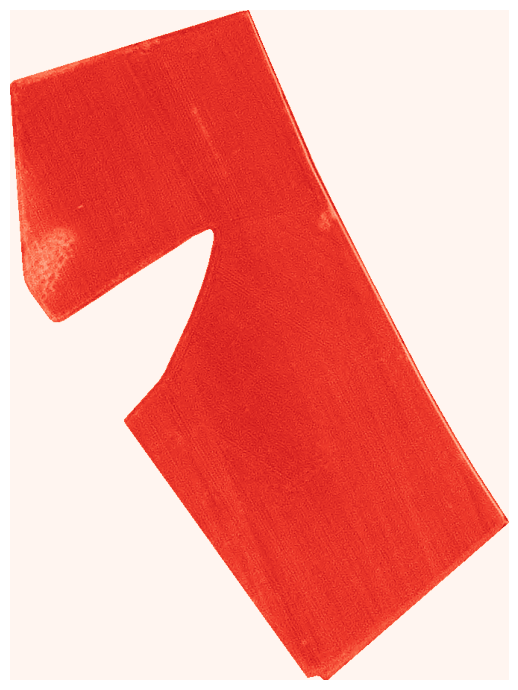

In [73]:
redn[band_mask] = np.nan
plot_raster_band(redn, cmap='Reds')


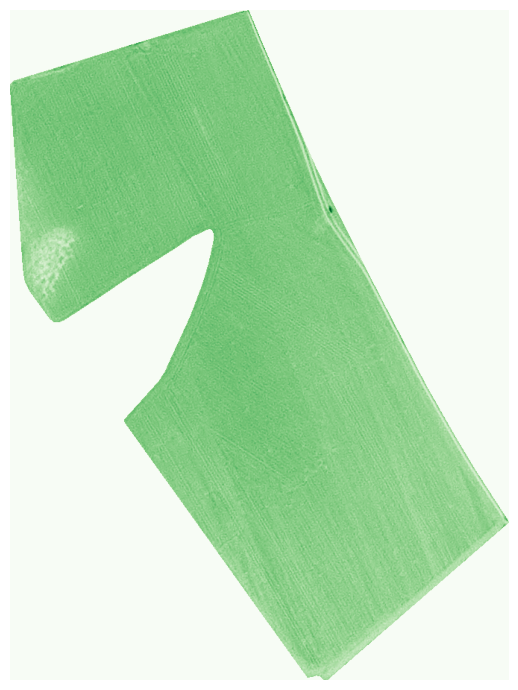

In [74]:
greenn[band_mask] = np.nan
plot_raster_band(greenn, cmap='Greens')


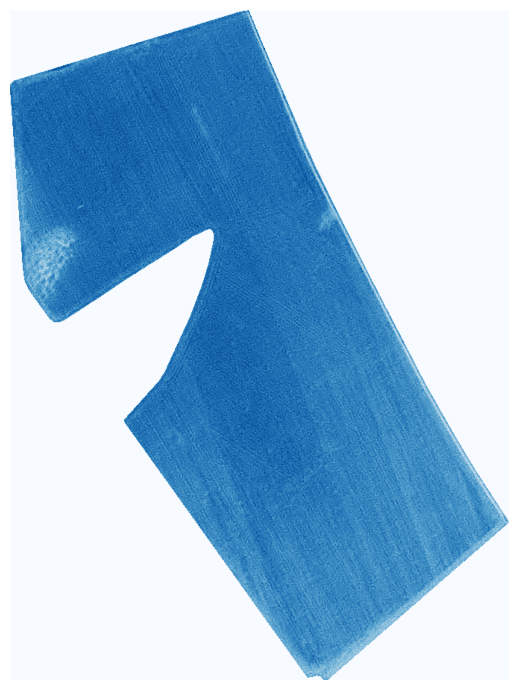

In [75]:
bluen[band_mask] = np.nan
plot_raster_band(bluen, cmap='Blues')

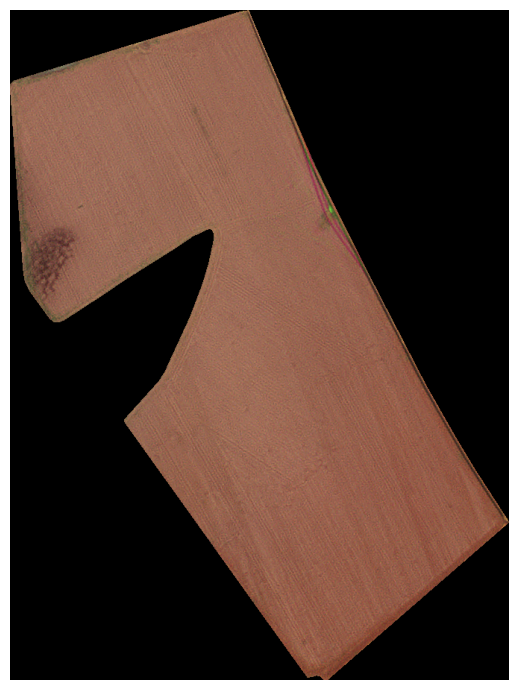

In [76]:
# Create RGB natural color composite
rgb = np.dstack((red, green, blue))
plot_raster_band(rgb, cmap=None)

### How remove the black background from an RGB image?

In [77]:
def remove_blue_background(buf: io.BytesIO, local_rgb_path: str) -> None:
    buf.seek(0)
    img = Image.open(buf)
    rgba = img.convert("RGBA")
    datas = rgba.getdata()

    newData = []

    for item in datas:
        if item[0] == 0 and item[1] == 0 and item[2] == 255:  # finding yellow colour
            # replacing it with a transparent value
            newData.append((255, 255, 255, 0))
        else:
            newData.append(item)
    rgba.putdata(newData)
    rgba.save(local_rgb_path, format='PNG')
    display(rgba)

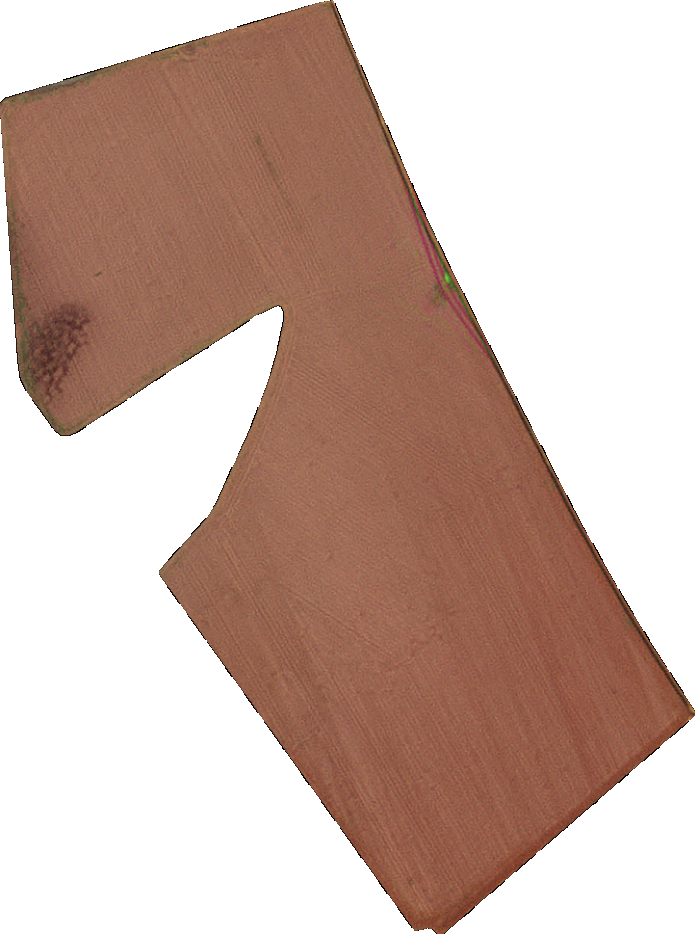

In [78]:
cmap = ListedColormap(['#0000FF'])
px = 1024
fig, ax = plt.subplots(
    figsize=(px / 300, px / 300), dpi=300)
ax.axis('off')
masked = np.ma.masked_where(np.nan_to_num(
    red, nan=0) != 0, np.nan_to_num(red, nan=0))
ax.imshow(rgb, extent=bounds_extent)
ax.imshow(masked, alpha=1, cmap=cmap, extent=bounds_extent)
ax.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
plt.tight_layout()
buf = io.BytesIO()
plt.savefig(buf, transparent=True,
            bbox_inches='tight',
            pad_inches=0,
            format='png',
            dpi=300)
plt.close()
remove_blue_background(buf = buf, local_rgb_path='data/outputs/rgb.png')

### Vegetation index

In [58]:
raster_path = 'data/original.tif'

raster = rasterio.open(raster_path)
bands = {'red':6, 'blue':2, 'green':4, 'nir':8, 'costal_blue':1, 'green_I':3,'yellow':5, 'red_edge':7}

In [79]:
raster_path = 'data/original.tif'

raster = rasterio.open(raster_path)
b = raster.bounds
bounds_extent = np.asarray([b.left, b.right, b.bottom, b.top])
bands = {'red':6, 'blue':2, 'green':4, 'nir':8, 'costal_blue':1, 'green_I':3,'yellow':5, 'red_edge':7}

# Convert to floats
red = raster.read(bands.get('red')).astype('f4')
nir = raster.read(bands.get('nir')).astype('f4')
red_edge =raster.read(bands.get('red_edge')).astype('f4')

np.seterr(divide='ignore', invalid='ignore')

# Calculate NDVI using numpy arrays
ndvi = (nir - red) / (nir + red)
ndre = (nir - red_edge)/(nir+red_edge)

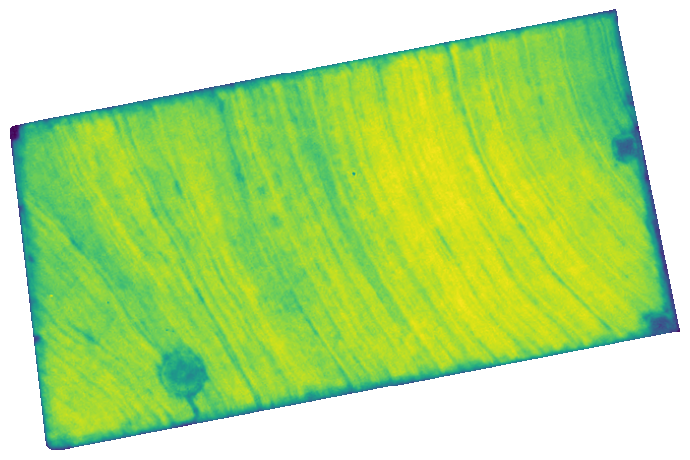

In [80]:
plot_raster_band(band=ndvi, cmap=None)

# Working with shape files

### Opening the file

In [81]:
gdf_base = gpd.read_file('data/basemap_shapefie/basemap.shp')
gdf_precipitation = gpd.read_file('data/precipitation_shapefile/precipitation.shp')

### Projections

When dealing with geospatial data, it's important to give due consideration to its attributes, particularly the projection. If you wish to merge or combine information, it is crucial to ensure that they share the same projection. 

In [82]:
gdf_precipitation.crs

<Derived Projected CRS: EPSG:31981>
Name: SIRGAS 2000 / UTM zone 21S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Brazil - between 60°W and 54°W, northern and southern hemispheres. In remainder of South America - between 60°W and 54°W, southern hemisphere, onshore and offshore.
- bounds: (-60.0, -44.82, -54.0, 4.51)
Coordinate Operation:
- name: UTM zone 21S
- method: Transverse Mercator
Datum: Sistema de Referencia Geocentrico para las AmericaS 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [83]:
gdf_base.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [84]:
gdf_base.to_crs(gdf_precipitation.crs, inplace=True)

### Ploting map

In [85]:
def plot_map_farm(df_base: gpd.GeoDataFrame, df_aditional_info: gpd.GeoDataFrame, title: str):
    fig, ax = plt.subplots(1,1, figsize=(5,5))
    base_map = df_base.plot(color='blue', edgecolor='black', ax = ax)
    precipitation = df_aditional_info.plot(ax=base_map, color='red', alpha= 1)
    fig.suptitle(title, fontsize=15, fontweight="bold")
    plt.xlabel(' ', fontsize=12)
    plt.ylabel(' ', fontsize=12)

    # # Remove axes splines
    for s in ['top', 'bottom', 'left', 'right']:
        ax.spines[s].set_visible(False)

    # Remove x, y Ticks
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    # Add padding between axes and labels
    ax.xaxis.set_tick_params(pad = 5)
    ax.yaxis.set_tick_params(pad = 10)

    # # Add x, y gridlines
    ax.grid(color ='darkgrey',
            linestyle ='-.', linewidth = 0.7,
            alpha = 0.2
            )

    # # Show top values
    ax.invert_yaxis()
    
    plt.show()

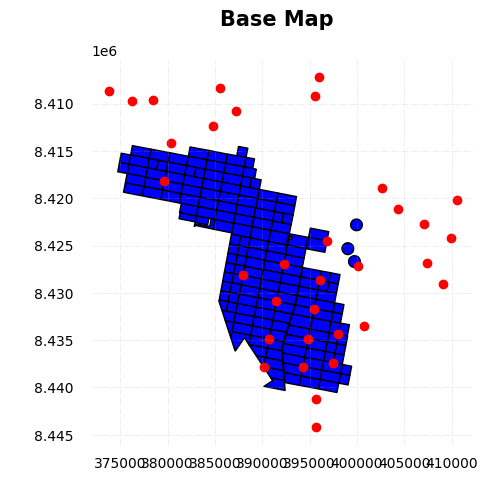

In [86]:

plot_map_farm(df_base=gdf_base, df_aditional_info=gdf_precipitation, title="Base Map")


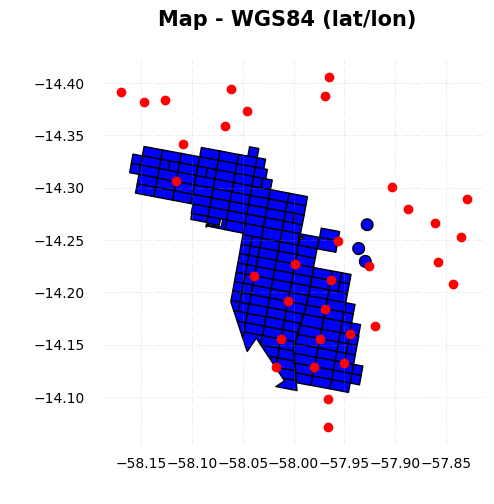

In [87]:
gdf_precipitation.to_crs('EPSG:4326', inplace=True)
gdf_base.to_crs('EPSG:4326', inplace=True)
plot_map_farm(df_base=gdf_base, df_aditional_info=gdf_precipitation, title='Map - WGS84 (lat/lon)')

### Spatial Interpolation

In [88]:
gdf_base.head()

,Talhao,geometry
0,0,"POLYGON ((-57.97856 -14.23261, -57.99662 -14.2..."
1,1,"POLYGON ((-57.99860 -14.22694, -58.00029 -14.2..."
2,2,"POLYGON ((-57.98200 -14.21463, -58.00028 -14.2..."
3,3,"POLYGON ((-57.98553 -14.19683, -58.00372 -14.2..."
4,4,"POLYGON ((-57.99582 -14.16163, -57.99304 -14.1..."


In [89]:
gdf_precipitation.head()

,precipitat,geometry
0,2162.0,POINT (-57.96488 -14.40550)
1,1710.0,POINT (-57.96887 -14.38773)
2,1598.0,POINT (-58.06799 -14.35847)
3,2179.0,POINT (-58.04627 -14.37316)
4,2096.0,POINT (-58.06140 -14.39435)


Note that our objective is to interpolate the points of `gdf_precipitation` to generate an $ n x n $ matrix. In this matrix, the coordinates $ x_i $ and $ y_j $ should satisfy the conditions:

* $ x_ {min} <x_i <x_ {max} $ 
* $ y_ { min} <y_i <y_ {max} $  

where `x_min` represents the minimum x-coordinate value in `gdf_base`, `x_max` represents the maximum x-coordinate value in `gdf_base`, `y_min` represents the minimum y-coordinate value, and `y_max` represents the maximum y-coordinate value in `gdf_base`. Once the matrix is created, it will be saved as a raster file. Finaly, we will utilize the `rasterio` library to extract all relevant information from our base map shapefile.

The following steps will be followed:


1. Define the values of $ x_ {min}, x_ {max}, y_ {min}, y_ {max} $. 

2. Create a one-dimensional array with n equally spaced points between $ x_ {min} $ and $ x_ {max} $ 

3. Create a one-dimensional array with n equally spaced points between $ y_ {min} $ and $ y_ {max} $ 

4. Interpolation: This will involve utilizing the X and Y coordinates of `gdf_precipitation`, along with the accumulated sum of rain (in mm) values, as input arguments. The interpolation will be conducted using a grid constructed from the vectors created in steps 2 and 3. The output will be an n x n array, denoted as `z`.

5. Save the interpolated array (Z) as a raster file. 

6. Read the raster file generated in step 5 using the `rasterio` library.

7. Apply the `mask` function from `rasterio` to exclude the interpolated values outside the base map region. This will involve utilizing an array that consists of the `geometry` column from `gdf_base`.

Steps 1, 2 and 3

In [90]:
# 1: define xmax, ymax, xmin and y min
min_x, min_y, max_x, max_y = gdf_base.total_bounds
# 2 and 3: Horizontal and vertical cell counts should be the same
n_points = 1000
xx_grid_coord = np.linspace(min_x, max_x, n_points)
yy_grid_coord = np.linspace(min_y, max_y, n_points)

Step 4: Interpolation

In [91]:
# 4: Interpolation
x_rain = gdf_precipitation["geometry"].x
y_rain = gdf_precipitation["geometry"].y
values_rain = list(gdf_precipitation.precipitat)
# Generate ordinary kriging object
OK = OrdinaryKriging(
    np.array(x_rain),
    np.array(y_rain),
    values_rain,
    variogram_model = "linear",
    verbose = False,
    enable_plotting = False,
    coordinates_type = "euclidean",
)

# execute the interpolation process using the method execute of our object.
interpolated_values, sigma_squared_p_krig = OK.execute("grid", xx_grid_coord, yy_grid_coord)

Step 5. Save interpolated array (Z) as a raster file.

In [92]:
# method to save an array as a raster file
def export_kde_raster(interpoolated_values: np.array, x_coord: np.array, y_coord: np.array, min_x, max_x, min_y, max_y, proj, filename: str):
    '''Export and save a kernel density raster.'''

    # Get resolution
    xres = (max_x - min_x) / len(x_coord)
    yres = (max_y - min_y) / len(y_coord)

    # Set transform
    transform = Affine.translation(min_x - xres / 2, min_y - yres / 2) * Affine.scale(xres, yres)

    # Export array as raster
    with rasterio.open(
            filename,
            mode = "w",
            driver = "GTiff",
            height = interpoolated_values.shape[0],
            width = interpoolated_values.shape[1],
            count = 1,
            dtype = interpoolated_values.dtype,
            crs = proj,
            transform = transform,
    ) as new_dataset:
            new_dataset.write(interpoolated_values, 1)

In [93]:
# Export raster
file_path = "data/outputs/precipitation_interpolated.tif"
export_kde_raster(interpoolated_values=interpolated_values, x_coord=xx_grid_coord, y_coord=yy_grid_coord,
min_x = min_x, max_x = max_x, min_y = min_y, max_y = max_y,
                  proj = gdf_precipitation.crs, 
                  filename = file_path)

Step 6. Read the file created using rasterio.

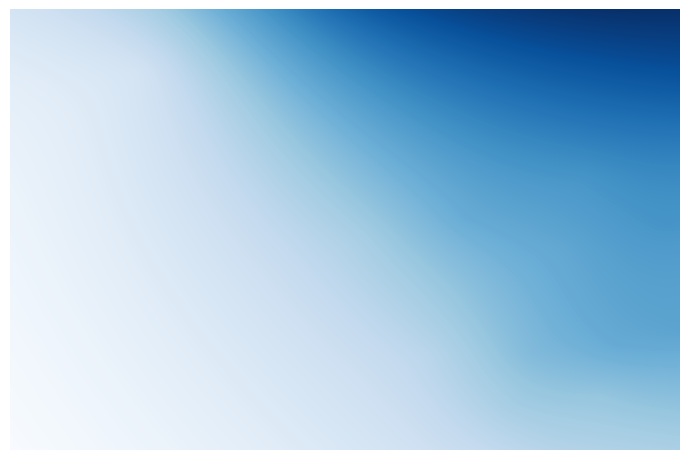

In [94]:
# Open raster
raster_interpolated = rasterio.open(file_path)
plot_raster_band(raster_interpolated.read(1), cmap='Blues')

In [95]:
# Create copy of test dataset
gdf_precipitation_copy = gdf_precipitation.copy()


Step 7: Masking the raster using `rasterio.mask.mask`

In [96]:
# Mask raster to counties shape
band_interpolated_masked, affine_transform_masked_raster_interpolated = mask(raster_interpolated, gdf_base.geometry.values, crop = True)

In [97]:
band_interpolated_masked

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [98]:
affine_transform_masked_raster_interpolated

Affine(0.0002397466625282405, 0.0, -58.16157490085823,
       0.0, 0.00023496674749191548, -14.339390829126286)

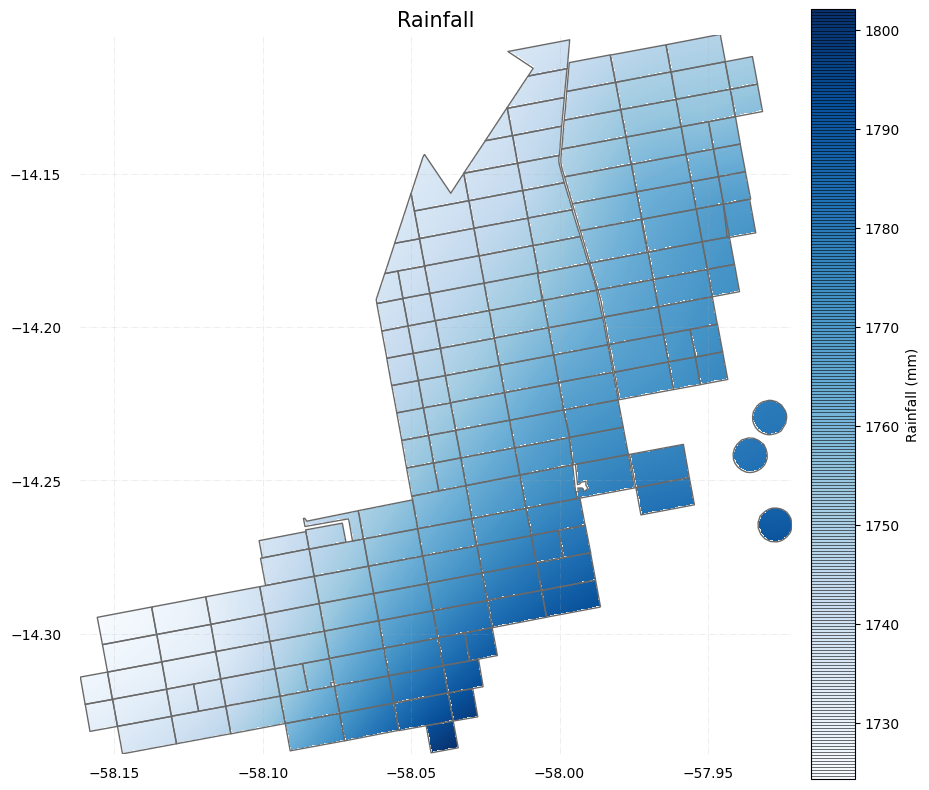

In [99]:
b = raster_interpolated.bounds
bounds_extent = np.asarray([b.left, b.right, b.bottom, b.top])
array_values = band_interpolated_masked.reshape(1000, 1000)
array_values = array_values.astype('float')
array_values[array_values == 0] = np.nan
# Plot data
fig, (ax, cbar_ax) = plt.subplots(1,2, figsize=(10,10), gridspec_kw={'wspace':0.05, 'width_ratios':(0.8,0.05)} )
cbar_kws={"label":"Rainfall (mm)","orientation":"vertical",
#  "ticks":[-1, -0.5,0, 0.5, 1], 
 "extendfrac":100, "drawedges":True }

precipitation_map = ax.imshow(array_values, cmap = "Blues", extent=bounds_extent)
# ax.plot(x_rain, y_rain, 'k.', markersize = 2, alpha = 0.5)
gdf_base.plot(ax = ax, color = 'none', edgecolor = 'dimgray')
# plt.gca().invert_yaxis()
plt.colorbar(precipitation_map, cax=cbar_ax, **cbar_kws)

# # Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)

# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

# # Add x, y gridlines
ax.grid(color ='darkgrey',
        linestyle ='-.', linewidth = 0.7,
        alpha = 0.2)

# # Show top values
ax.invert_yaxis()

# Set title
ax.set_title('Rainfall', fontdict = {'fontsize': '15', 'fontweight' : '3'})

# Display plot
plt.show()

Here are some tutorials that provide tips on geospatial data manipulation using Python:

"Introduction to Geospatial Data Manipulation with Python" - PyGIS.io

Link: https://pygis.io/docs/a_intro.html
"Raster Map Algebra with Python" - Automating GIS Processes

Link: https://automating-gis-processes.github.io/CSC/notebooks/L5/raster-map-algebra.html
These tutorials offer valuable insights and guidance on manipulating geospatial data using Python, providing you with useful tips and techniques.

If you are starting your journey in working with spatial data, I recommend reading Chapter 2 of the book "Python Geospatial Development" by Erik Westra. This chapter can provide valuable insights and foundational knowledge in the field of geospatial development.

Here is the link to the book on Amazon: [Python Geospatial Development](https://www.amazon.com/Python-Geospatial-Development-Erik-Westra/dp/1785288938)